In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm
from sklearn.model_selection import train_test_split

In [2]:
def sampling(x, num):
    l, r = -1, 1 #左区间、右区间
    for i in range(num):
        rand_num = random.random() # 生成[0,1]之间的随机数
        mapped_num = (r - l) * rand_num + l
        x.append(mapped_num)

In [3]:
np.random.seed(77)
numbers = 100
x_regression = []
sampling(x_regression, numbers)
x_classification = []
sampling(x_classification, numbers)
len(x_regression), len(x_classification)

(100, 100)

In [4]:
#定义噪声
def noise(mu, sigma, num):
    return np.random.normal(mu, sigma, num)
#定义sign函数
def sgn(x):
    return np.where(x > 0, 1, -1)

In [5]:
x_regression = np.array(x_regression)
x_classification = np.array(x_classification)
y_regression = 0.36*x_regression + 0.65*x_regression**2 + 0.12*x_regression**3 - 0.32 *x_regression**4 + 0.75 * x_regression**5 - 0.54*x_regression**6 + 0.1*noise(0,0.1,numbers) 
y_classification = sgn(0.36*x_classification + 0.65*x_classification**2 + 0.12*x_classification**3 - 0.32 *x_classification**4 + 0.75 * x_classification**5 - 0.54*x_classification**6 + 0.1*noise(0,0.1,numbers)) 

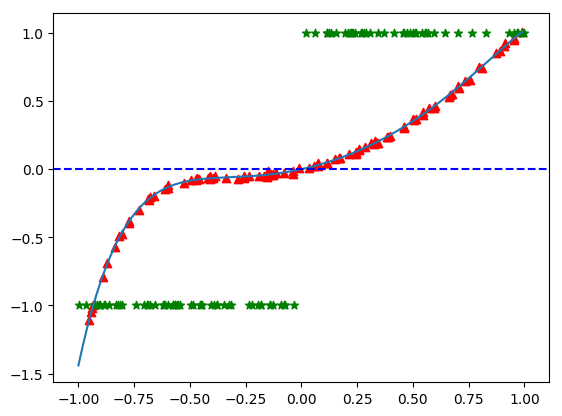

In [6]:
# 创建一个numpy数组x，范围为-10到10，步长为0.1
x = np.arange(-1, 1, 0.01)
y = 0.36*x + 0.65*x**2 + 0.12*x**3 - 0.32 *x**4 + 0.75 * x**5 - 0.54*x**6
plt.plot(x, y)
plt.scatter(x_regression, y_regression, c='r', marker='^')
plt.scatter(x_classification, y_classification, c='g', marker='*')
plt.axhline(y=0, color='b', linestyle='--')

plt.show()

In [7]:
def power_basis(x, degree): #幂函数
    phi = np.zeros((len(x), degree+1))
    for i in range(degree+1):
        phi[:, i] = np.power(x, i)
    return phi

In [8]:
x_regression_mi6 = power_basis(x_regression, 6)
x_y_regression6 = np.concatenate([x_regression_mi6,y_regression.reshape(numbers,1)],axis=1)

x_classification_mi6 = power_basis(x_classification, 6)
x_y_classification6 = np.concatenate([x_classification_mi6,y_classification.reshape(numbers,1)],axis=1)

随机梯度下降法SGD最终训练的分类系数：
x1   nan
x2   nan
x3   nan
x4   nan
x5   nan
x6   nan
x7   nan


/home/ubuntu/anaconda3/envs/zhc/lib/python3.7/site-packages/ipykernel_launcher.py:93: RuntimeWarning: invalid value encountered in true_divide
/home/ubuntu/anaconda3/envs/zhc/lib/python3.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in greater
/home/ubuntu/anaconda3/envs/zhc/lib/python3.7/site-packages/ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in log
/home/ubuntu/anaconda3/envs/zhc/lib/python3.7/site-packages/ipykernel_launcher.py:125: RuntimeWarning: invalid value encountered in greater


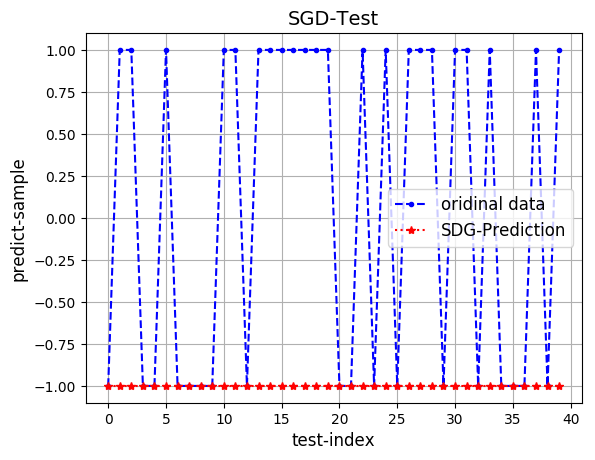

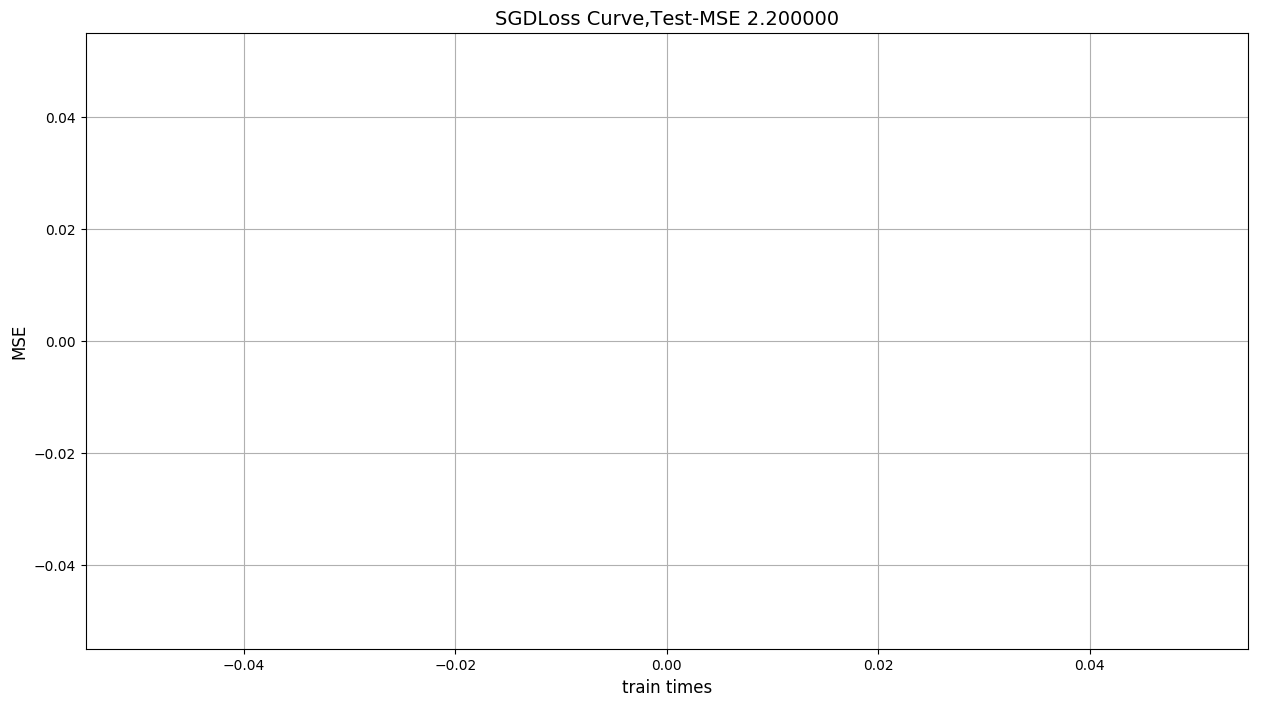

x1   nan
x2   nan
x3   nan
x4   nan
x5   nan
x6   nan
x7   nan
[nan nan nan nan nan nan nan]
nan
nan
nan
nan
nan
nan
nan
随机梯度下降法SGD最终训练的回归系数：


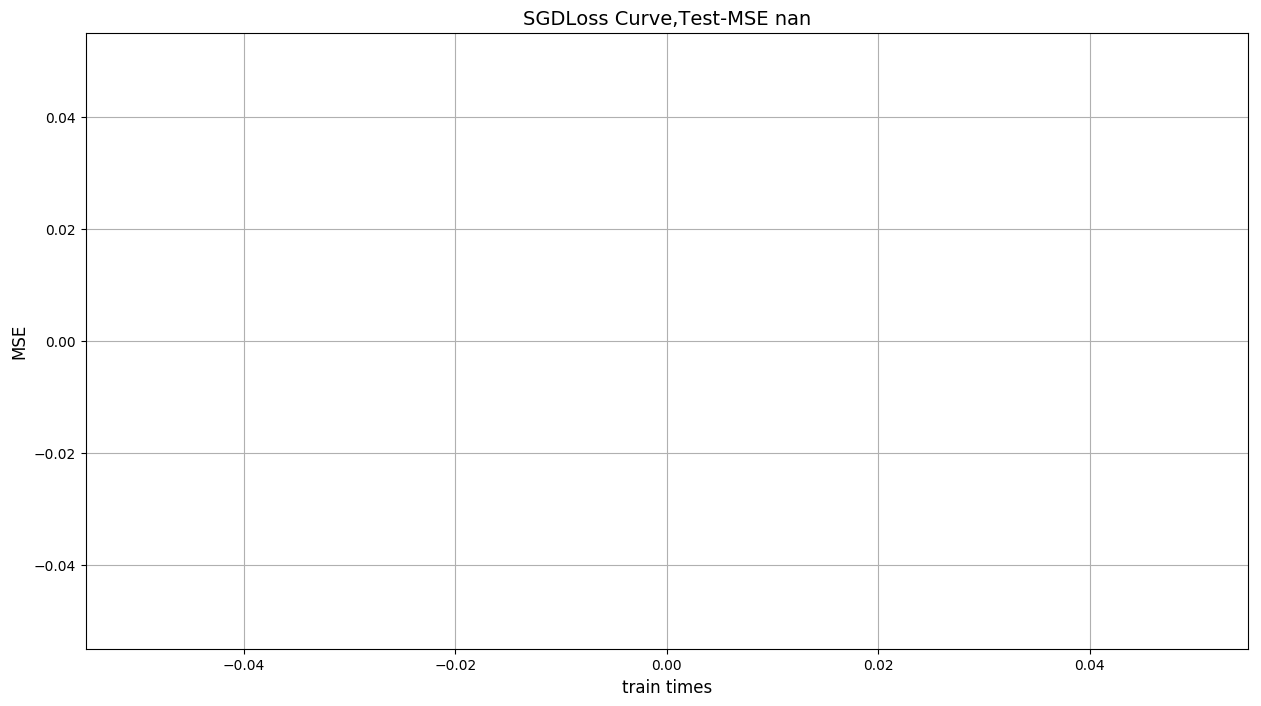

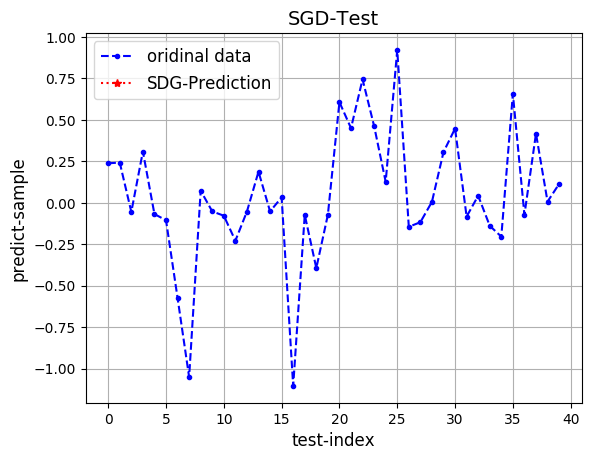

In [84]:
class GD_Linear_Model():
    def __init__(self, data, feature_list, alpha, beta, sigma):
        self.data = pd.DataFrame(data) #读取数据
        
        self.feature_labels = feature_list[:-1] #特征标签
        self.target_label = feature_list[-1] #目标值
        
        self.data_scale = self.data #StandardScaler().fit_transform(self.data) #数据标准化 
        
        self.X = np.array(self.data_scale.iloc[:, :-1])  #取X 
        self.y = np.array(self.data_scale.iloc[:, -1])  #取y

        
        self.x_train, self.x_test, self.y_train, self.y_test = \
            train_test_split(self.X, self.y, train_size=0.6, random_state=42)  #数据集划分
        
        self.alpha = alpha  #步长
        self.beta = beta #正则化因子
        self.sigma = sigma
        self.n, self.k = self.x_train.shape #训练集的大小和特征数量
        
    def sgd_regression_train(self, reweight, loop_max, threshold):
        np.random.seed(77) #设置随机数种子方便复现实验
        weight = reweight  # 使用正态分布随机初始化权重
        alpha_lr = self.alpha  # 用于衰减指数 我们先固定
        beta_lr = self.beta #用于正则化因子
        sigma_lr = self.sigma
        sdg_weight = dict()  # 存储权重更新过程值
        
        for j in range(self.k):
            sdg_weight[str(j)] = []
        train_loss_mean = []  # 存储训练过程中的误差损失
        weight_old = weight
        loop = 0  # 训练迭代变量
        for loop in range(loop_max):  # 外层循环，不断进行迭代
            alpha_lr *= 0.95  # 衰减指数0.95
            index = np.random.permutation(self.n)  # 样本索引号打乱
            train_X = self.x_train[index]  # 打乱训练数据样本
            train_y = self.y_train[index]
            for i in range(self.n):
                z = self.probit(train_X[i], weight)
                y_hat = train_X[i].dot(weight.T)
                weight = weight + alpha_lr * (-beta_lr * (y_hat - train_y[i]) * train_X[i] -  sigma_lr * weight)
            for j in range(self.k):
                sdg_weight[str(j)].append(weight[j])
            # 存储误差损失平方和平均值
            train_loss_mean.append(((train_X.dot(weight.T) - train_y) ** 2).mean()) 
            # 判断相邻两次权重更新变化，当变化小于给定阀值的时候，提前停止训练
            if np.abs(weight - weight_old).all() < threshold:
                break
            else:
                weight_old = weight

                
        print(weight) 
        for j in range(self.k):
                print(sdg_weight[str(j)][-1])
        y_test_hat, loss_test = self.predict(weight)  # 预测
        model_info_dict = self.model_info(loop + 1, train_loss_mean, sdg_weight, y_test_hat, loss_test)
        return model_info_dict
    
    def probit(self, x, w):
        # 计算Probit函数的值
        return norm.cdf(np.dot(x, w))

    def probit_gradient(self, x, w):
        # 计算Probit函数的梯度
        return norm.pdf(np.dot(x, w)) * x
    
    def sgn(self, x):
        return np.where(x > 0, 1, -1)
    
    def sgd_classification_train(self, re_weight, loop_max, threshold):
        np.random.seed(77) #设置随机数种子方便复现实验
        weight = re_weight  # 使用正态分布随机初始化权重
        alpha_lr = self.alpha  # 用于衰减指数 我们先固定
        beta_lr = self.beta #用于正则化因子
        sigma_lr = self.sigma
        sdg_weight = dict()  # 存储权重更新过程值

        for j in range(self.k):
            sdg_weight[str(j)] = []
        train_loss_mean = []  # 存储训练过程中的误差损失
        weight_old = weight
        loop = 0  # 训练迭代变量
        for loop in range(loop_max):  # 外层循环，不断进行迭代
            alpha_lr *= 0.95  # 衰减指数0.95
            index = np.random.permutation(self.n)  # 样本索引号打乱
            train_X = self.x_train[index]  # 打乱训练数据样本
            train_y = self.y_train[index]
            for i in range(self.n):                
                z = self.probit(train_X[i], weight)
                weight = weight + alpha_lr * (self.probit_gradient(train_X[i], weight) * train_y[i] / z - sigma_lr * weight)
            for j in range(self.k):
                sdg_weight[str(j)].append(weight[j])
            # 存储误差损失平方和平均值
            yes_or_no = self.sgn(train_X.dot(weight.T) * train_y)
            if np.any(yes_or_no < 0):
                train_loss_mean.append(np.mean(-np.log(yes_or_no)))
            # 判断相邻两次权重更新变化，当变化小于给定阀值的时候，提前停止训练
            if np.abs(weight - weight_old).all() < threshold:
                break
            else:
                weight_old = weight
        y_test_hat, loss_test = self.predict1(weight)  # 预测
        model_info_dict = self.model_info(loop + 1, train_loss_mean, sdg_weight, y_test_hat, loss_test) 
        return model_info_dict

    def model_info(self, loop, loss_train, weight, y_test_hat, loss_test):
        model_info_dict = dict()
        model_info_dict["loop"] = loop
        model_info_dict["loss_train"] = loss_train
        model_info_dict["weight"] = weight
        model_info_dict["y_test_hat"] = y_test_hat
        model_info_dict["loss_test"] = loss_test
        return model_info_dict

    def predict(self, weight):
        y_test_hat = self.x_test.dot(weight.T)
        loss_test = ((y_test_hat - self.y_test) ** 2).mean()
        return y_test_hat, loss_test
    
    def predict1(self, weight):
#         y_test_hat = self.sgn(self.x_test @ weight.T)
        y_test_hat = np.where(self.probit(self.x_test, weight) > 0.5, 1, -1)
        loss_test = ((y_test_hat - self.y_test) ** 2).mean()
        return y_test_hat, loss_test
    
    def classification_predict(self, weight):
        y_test_hat = self.sgn(self.x_test.dot(weight.T))  # 使用sign函数进行分类
        y_test_hat[y_test_hat == 0] = -1  # 将0标签转换为-1
        accuracy = (y_test_hat == self.y_test).mean()  # 计算分类准确率
        return y_test_hat, accuracy
    def plt_loss_weight(self, sgd_info_dict):
        def plt_loss(info_dict, title):
            plt.plot(info_dict["loss_train"], 'b-')
            plt.xlabel("train times", fontdict={"fontsize": 12})
            plt.ylabel("MSE", fontdict={"fontsize": 12})
            plt.title(title + "Loss Curve,Test-MSE %f" %
                      info_dict["loss_test"], fontdict={"fontsize": 14})
            plt.grid()

        def plt_weight(info_dict, title):
            for j in range(self.k):
                plt.plot(info_dict["weight"][str(j)], label=self.feature_labels[j])
            plt.xlabel("Weight update times", fontdict={"fontsize": 12})
            plt.ylabel("feature-weight", fontdict={"fontsize": 12})
            plt.title(title + "regression-update-curve", fontdict={"fontsize": 14})
            plt.grid()
            plt.legend(fontsize=12)

        plt.figure(figsize=(15, 8))
        plt_loss(sgd_info_dict, "SGD")
#         plt_weight(sgd_info_dict, "SGD")
        plt.show()

    def plt_predict(self, sgd_info_dict):
        # 绘制预测值与真实值对比图 #self.y
        plt.plot(self.y_test, 'b.--', label="oridinal data")
        plt.plot(sgd_info_dict["y_test_hat"], 'r*:', label="SDG-Prediction")
        plt.xlabel("test-index", fontdict={"fontsize": 12})
        plt.ylabel("predict-sample", fontdict={"fontsize": 12})
        plt.title("SGD-Test", fontdict={"fontsize": 14})
        plt.legend(fontsize=12)
        plt.grid()
        plt.show()
        
    def plt_predict1(self, sgd_info_dict):
        # 绘制预测值与真实值对比图 #self.y
        plt.plot(self.y_test, 'b.--', label="oridinal data")
        plt.plot(self.sgn(sgd_info_dict["y_test_hat"]), 'r*:', label="SDG-Prediction")
        plt.xlabel("test-index", fontdict={"fontsize": 12})
        plt.ylabel("predict-sample", fontdict={"fontsize": 12})
        plt.title("SGD-Test", fontdict={"fontsize": 14})
        plt.legend(fontsize=12)
        plt.grid()
        plt.show()

if __name__ == '__main__':
#     attribute_list = ["x1","x2","x3","x4","x5","x6","x7","x8","x9","x10","y"]#["x1","x2","x3","bias","y"]
    attribute_list = ["x1","x2","x3","x4","x5","x6","x7","y"]
    
    alpha = 10  
    beta = 10
    sigma = 10
    weight = np.random.random(7)  # 使用正态分布随机初始化权重

    data1 = x_y_classification6
    gdlm = GD_Linear_Model(data1, attribute_list, alpha, beta, sigma)
    sgd_info_dict = gdlm.sgd_classification_train(weight, 10, 1e-6)
    print("=" * 70)
    print("随机梯度下降法SGD最终训练的分类系数：")
    for i in range(gdlm.k):
        print(attribute_list[i], " ", sgd_info_dict["weight"][str(i)][-1])
    print("=" * 70)
    gdlm.plt_predict1(sgd_info_dict)
    gdlm.plt_loss_weight(sgd_info_dict)

    weight = []
    for i in range(gdlm.k):
        weight.append(sgd_info_dict["weight"][str(i)][-1]) 
        print(attribute_list[i], " ", sgd_info_dict["weight"][str(i)][-1])
    weight = np.array(weight)
    

    data = x_y_regression6
    gdlm = GD_Linear_Model(data, attribute_list, alpha, beta, sigma)
    sgd_info_dict = gdlm.sgd_regression_train(weight, 100, 1e-6)
    print("=" * 70)
    print("随机梯度下降法SGD最终训练的回归系数：")
    print("=" * 70)
    gdlm.plt_loss_weight(sgd_info_dict)
    gdlm.plt_predict(sgd_info_dict)
    
    weight = []
    for j in range(100):
        for i in range(gdlm.k):
            weight.append(sgd_info_dict["weight"][str(i)][-1-j]) 
#             print(attribute_list[i], " ", sgd_info_dict["weight"][str(i)][-1-j])
    weight = np.array(weight)
    

In [75]:
# 分割后的新数组列表
w_list = [weight[i:i+7] for i in range(0, len(weight), 7)]

# 打印每个新数组
for i, w in enumerate(w_list):
    print(f"w{i+1}: {w}")


w1: [0.00938815 0.0223656  0.00456503 0.01541993 0.0031315  0.01191913
 0.00259422]
w2: [0.00938801 0.02236249 0.00456491 0.01541725 0.00313132 0.0119168
 0.00259398]
w3: [0.0093906  0.02236392 0.00456626 0.01541794 0.00313224 0.0119171
 0.00259466]
w4: [0.00939299 0.02236745 0.00456819 0.01542087 0.00313371 0.01191953
 0.00259584]
w5: [0.00939368 0.02236718 0.00456813 0.01542028 0.00313361 0.01191884
 0.00259574]
w6: [0.00939516 0.02236827 0.00456892 0.01542106 0.00313448 0.01191957
 0.00259672]
w7: [0.00939318 0.02236861 0.00456889 0.01542208 0.00313521 0.01192094
 0.00259781]
w8: [0.00939768 0.02237022 0.00457245 0.01542352 0.00313818 0.01192229
 0.00260037]
w9: [0.00940554 0.0223692  0.004578   0.01542246 0.00314245 0.01192131
 0.0026038 ]
w10: [0.00940673 0.0223685  0.00457742 0.01542082 0.00314109 0.01191931
 0.00260213]
w11: [0.00940205 0.02237013 0.00457239 0.01542147 0.00313653 0.01191946
 0.00259809]
w12: [0.00941639 0.02236684 0.00458357 0.01541893 0.0031456  0.01191744
 0.0

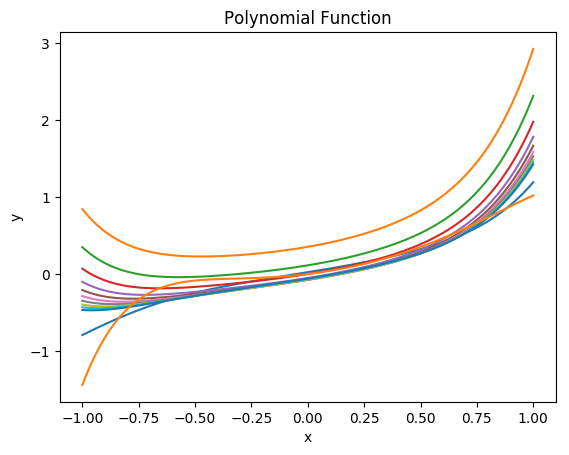

In [61]:
def polynomial(w, x):
#     y = w[0] + w[1]*x + w[2]*x**2 + w[3]*x**3
    y = w[0]*1 + w[1]*x + w[2]*x**2 + w[3]*x**3 + w[4]*x**4 + w[5]*x**5+ w[6]*x**6
    return y

w = w_list[0]
w1 = w_list[-1]
w2 = w_list[-2]
w3 = w_list[-3]
w4 = w_list[-4]
w5 = w_list[-5]
w6 = w_list[-6]
w7 = w_list[-7]
w8 = w_list[-8]
w9 = w_list[-9]
w10 = w_list[-10]
x = np.linspace(-1, 1, num=1000)  # 生成100个均匀分布的x值
y = polynomial(w, x)  # 计算对应的y值
y1 = polynomial(w1, x)  # 计算对应的y值
y2 = polynomial(w2, x)  # 计算对应的y值
y3 = polynomial(w3, x)  # 计算对应的y值
y4 = polynomial(w4, x)  # 计算对应的y值
y5 = polynomial(w5, x)  # 计算对应的y值
y6 = polynomial(w6, x)  # 计算对应的y值
y7 = polynomial(w7, x)  # 计算对应的y值
y8 = polynomial(w8, x)  # 计算对应的y值
y9 = polynomial(w9, x)  # 计算对应的y值
y10 = polynomial(w10, x)  # 计算对应的y值
plt.plot(x, y)
plt.plot(x, y1)
plt.plot(x, y2)
plt.plot(x, y3)
plt.plot(x, y4)
plt.plot(x, y5)
plt.plot(x, y6)
plt.plot(x, y7)
plt.plot(x, y8)
plt.plot(x, y9)
plt.plot(x, y10)
y_true = 0.36*x + 0.65*x**2 + 0.12*x**3 - 0.32 *x**4 + 0.75 * x**5 - 0.54*x**6
plt.plot(x, y_true)
# 绘制图像
plt.xlabel('x')
plt.ylabel('y')
plt.title('Polynomial Function')
plt.savefig('图4.jpg')
plt.show()


In [54]:
w = w_list[0]
w1 = w_list[1]
w2 = w_list[-1]
w,w1,w2

(array([ 0.02328206,  0.47955852,  0.09015356,  0.29532336, -0.15306588,
         0.21760984,  0.23979387]),
 array([ 0.02325947,  0.47956159,  0.09017497,  0.29531357, -0.15303019,
         0.21759962,  0.23983271]),
 array([0.35351578, 0.5084589 , 0.57959788, 0.3006962 , 0.30304981,
        0.2312039 , 0.64700891]))